# Overview

This notebook contrasts the storage efficiency, CPU and memory utilization percentage for erasure coding and replication fault tolerance schemas. Both scenarios were tested under the same conditions using the same machines and data. This includes a single *controller*, single *client* and 11 *chunk servers* as shown in the table below. A single zip file yielding 1,638,588,690 bytes, or roughly 1.6386 GB, was used as a benchmark for uploading into the system. Metrics were gathered for each process (PID) using the Unix operating system command `top`. This command was used to capture data over 10 milliseconds intervals and where results can be appended to an appropriate output file. 

| Component     	| Machine       |
|---------------	|------      	|
| Client        	| lincoln   	|
| Controller    	| jackson       |
| Chunk Servers 	| pierre, saturn, neptune, hartford, montpelier, lamborghini, des-moines, montgomery, salt-lake-city, jefferson-city 	|

Each experiment was executed with the following steps; (a) Execute the `run.sh` script to initialize each component leaving idle for 10 seconds for a *healthy* startup, then (b) run the `scripts/run-monitor.sh` script to start monitoring each component on their associated machine. Thereafter, (c) upload the zip file, using the client, to the file system and wait for completion, then (d) allow the systems to *cool* for 15 seconds before marking the end of the trial.

During this process, the file fragments get stored at the local `/tmp` directory where they could later be retrieved. In the scenario using replication, the system is configured with a replication factor of three. This means that the file with it's individual chunks therein are distributed three times totaling a distributed file size of 4.9158 GB. With fairness implemented, this equates to each chunk server hosting 0.4469 GB of data. 

In contrast, the the schema for erasure coding using Reed-Solomon encoding increases the file size minimally as compared to fault tolerance with replication. Each of the 25,603 64 KB chunks of the file are broken into six fragments, and then encoded into three additional parity fragments. These nine fragments are then dispersed across the file system. Adding parity information increases each chunk size by 32,001 bytes for an increase of 819,321,603 bytes, or 0.8193 GB, totaling 2.4579 GB for the entire file. With fair distribution, this equates to 0.2235 GB of data being written on each chunk server.

Initial comparison show the schema for replication having a nearly two time greater space complexity on each chunk server. This means the client will be delivering more messages with the erasure coded chunks, but the message size and chunk servers themselves store less data.  

Understanding space complexity is important, but further evaluating the resource utilization of each component provides further insight. Find more details on the analyses in the [Experimental Analysis](#Experimental-Analysis).  

# Data Wrangling  

The following cells organize the data and define the functions that will be helpful in plotting.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
names = ['PID', 'USER', 'PR', 'NI', 'VIRT', 'RES', 'SHR', 'S', '%CPU', '%MEM', 'TIME+', 'COMMAND']

erasure_path = r'../scripts/results/export-bin-erasure'
erasure_clients = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(erasure_path + "/*Client.txt")]
erasure_control = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(erasure_path + "/*Controller.txt")]
erasure_servers = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(erasure_path + "/*ChunkServer.txt")]

replication_path = r'../scripts/results/export-bin-replication'
replication_clients = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(replication_path + "/*Client.txt")]
replication_control = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(replication_path + "/*Controller.txt")]
replication_servers = [pd.read_csv(f, names=names, delim_whitespace=True) 
                   for f in glob.glob(replication_path + "/*ChunkServer.txt")]

Each dataframe contains ~5,000 samples where each sample is captured on 10 millisecond intervals. Therefore, the the total experiment lasted for roughly 50 seconds. Viewing one of the dataframes content shows how the values are formatted as returned from `top`. For the purpose of this evaluation, the following will be used for comparison:  

- %CPU  --  CPU usage
      The task's share of the elapsed CPU time since the last screen
      update, expressed as a percentage of total CPU time.

- %MEM  --  Memory usage (RES)
      A task's currently used share of available physical memory.

In [3]:
erasure_clients[0].head()

,PID,USER,PR,NI,VIRT,RES,SHR,S,%CPU,%MEM,TIME+,COMMAND
0,28171,stock,20,0,11.6g,31672,16464,S,0.0,0.1,0:00.21,java
1,28171,stock,20,0,11.6g,31672,16464,S,0.0,0.1,0:00.21,java
2,28171,stock,20,0,11.6g,31672,16464,S,0.0,0.1,0:00.21,java
3,28171,stock,20,0,11.6g,31672,16464,S,0.0,0.1,0:00.21,java
4,28171,stock,20,0,11.6g,31672,16464,S,0.0,0.1,0:00.21,java


In [4]:
def averaged_chunk(df_list, column_index, truncate=False):
    x = np.array(df_list[0][column_index][250 if truncate else 0:-1])
    for i in range(1, len(df_list)):
        n = np.array(df_list[i][column_index])
        x_s, n_s = x.shape[0], n.shape[0]
        if (n_s < x_s):
            x.resize(n_s)
        else:
            n.resize(x_s)
        x += n
    return x / len(df_list)

def polyfit(y):
    x = np.arange(len(y))
    p15 = np.poly1d(np.polyfit(x, y, 15))
    xp = np.linspace(0, len(y) - 1, 1000)
    
    return xp, p15

def plot(title, erasure_list, replication_list):
    plt.figure(figsize=(18,18))
    plt.subplot(2, 1, 1)  

    y_erasure_cpu = averaged_chunk(erasure_list, '%CPU', True)
    xp, p15 = polyfit(y_erasure_cpu)
    plt.plot(xp, p15(xp), label='erasure')

    y_replication_cpu = averaged_chunk(replication_list, '%CPU')
    xp, p15 = polyfit(y_replication_cpu)
    plt.plot(xp, p15(xp), label='replication')

    plt.title(title + ' CPU %')
    plt.legend(loc='best', fontsize='large')
    plt.xlabel('Time Sequence 10(ms)'), plt.ylabel('Percentage');

    plt.subplot(2, 1, 2)  
    y_erasure_mem = averaged_chunk(erasure_list, '%MEM', True)
    plt.plot(y_erasure_mem, label='erasure')

    y_replication_mem = averaged_chunk(replication_list, '%MEM')
    plt.plot(y_replication_mem, label='replication')

    plt.title(title + ' Memory %')
    plt.legend(loc='best', fontsize='large')
    plt.xlabel('Time Sequence 10(ms)'), plt.ylabel('Percentage');

# Experimental Analysis  

Through monitoring each application it was possible to record the CPU and memory percentage throughout program execution. When evaluating the CPU percentage, it is unclear how the value changes over time due to sporadic fluctuations. Therefore, we can fit a non-linear polynomial to the the data to derive an averaged approximation of the value at any given instance. Inherently, this leads to values of zero after spikes in usage to dip below zero - it is not possible to have negative CPU usage, but exercises the approximation function. Furthermore, the percentage values greater than 100 are seen due to `top` evaluating the task's share of the elapsed CPU time, as a percentage of total CPU time, for all cores in the CPU.

## Client Comparison  

It is evident that the resource usage from the client is much more taxing with erasure coding as compared to the schema for replication. This is due to each 64 KB chunk being divided into fragments and encoded before being delivered to the chunk servers. Not only is this an expensive operation, but it is an additional step that is not encountered in replication.  

While the resource values are much higher, they are also experienced over a great period of time for CPU utilization. If the uploaded occurred at a time-stamp of 10 seconds, then the utilization for the replication schema reached 0% by a time-stamp of ~32 seconds. Whereas, the CPU utilization with erasure coding spanned to a time-stamp of ~42 seconds - 10 seconds later than that of replication. The time differences are not comparable with memory percentage as the plot for erasure coding is shown plateauing about the same time as replication, but with a much higher value.

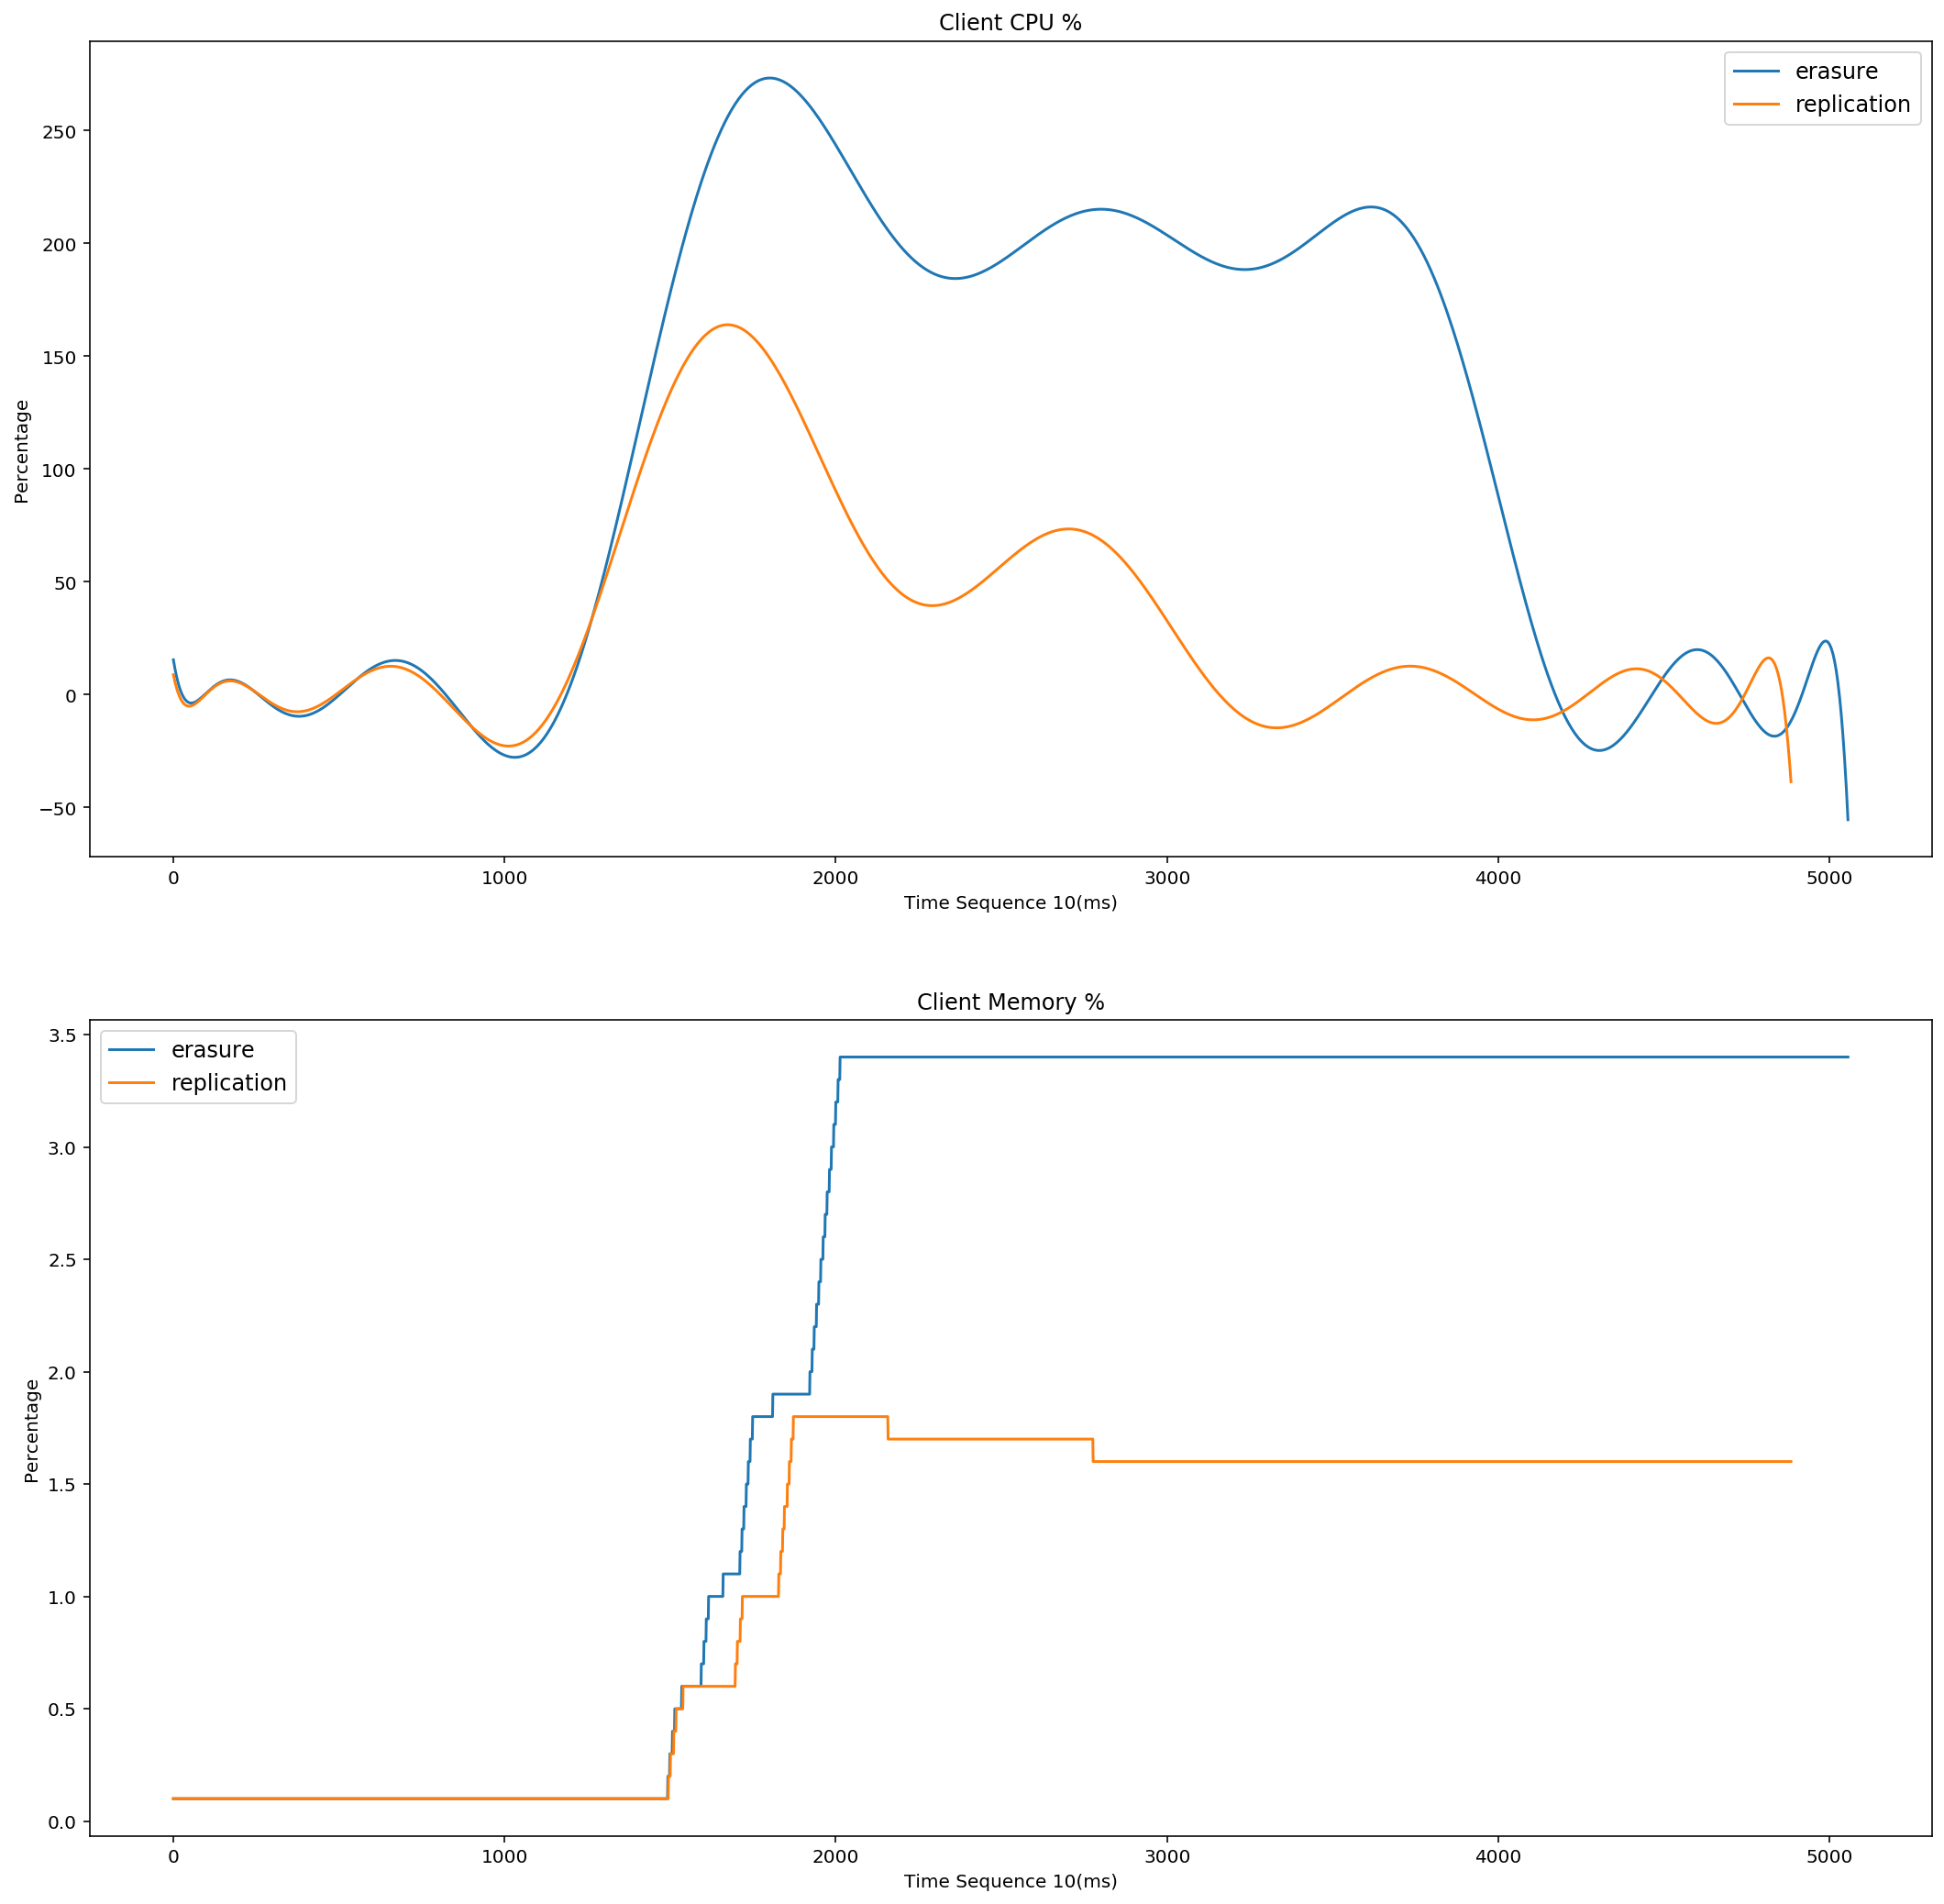

In [5]:
plot('Client', erasure_clients, replication_clients)

## Controller Comparison  

Resource utilization is nearly identical for both experiments in CPU and memory usage. This is due to the involvement of the controller being executed before any logical differences on the client. The large spike at a time-stamp of ~18 seconds is seen to a influx of requests from the client, where a response is shortly delivered thereafter. 

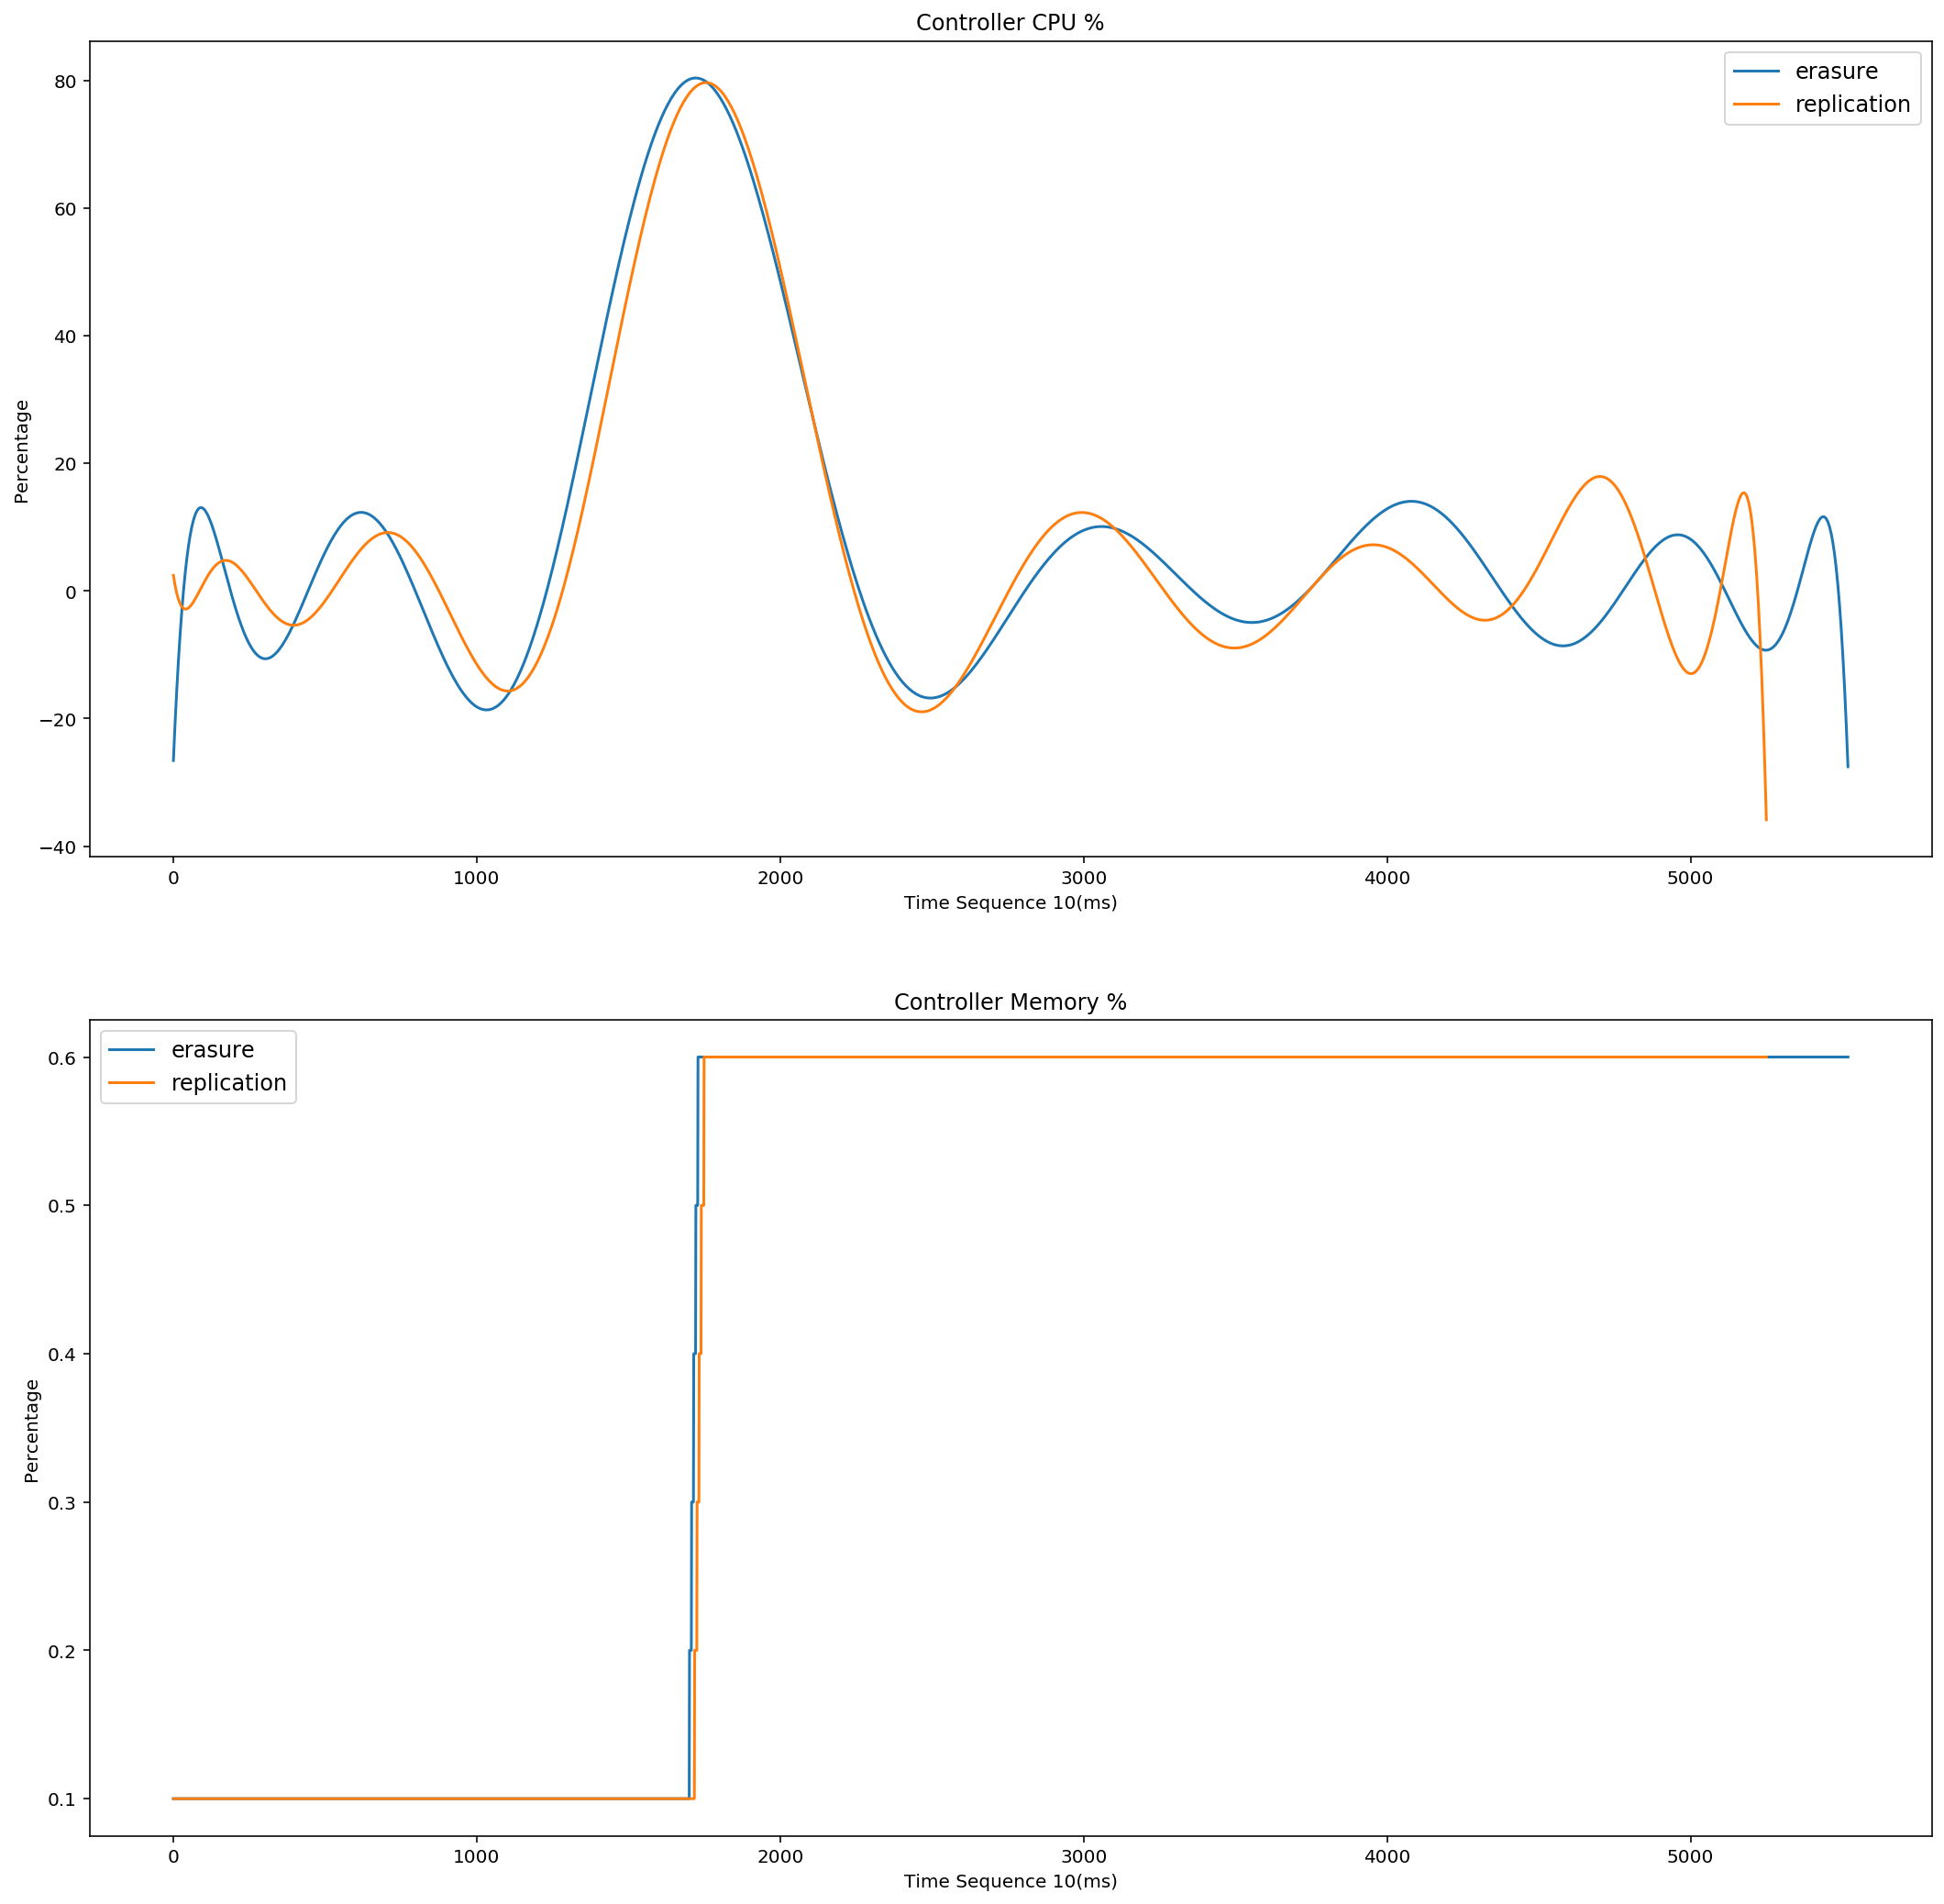

In [6]:
plot('Controller', erasure_control, replication_control)

## Chunk Server Comparison  

Within this experimental configuration there are 11 chunk servers. Thus, resource metrics for these servers are averaged for each sample to provide an overview of how all the servers are performing. Similar to the client, it can be seen that the elapsed time for erasure coding exceeds that of replication, which due to the hang time on awaiting requests from the client. However, the peak usage is similar for both schemas for CPU utilization, indicating that a similar amount work is being used for writing the messages to disk and forwarding the requests.

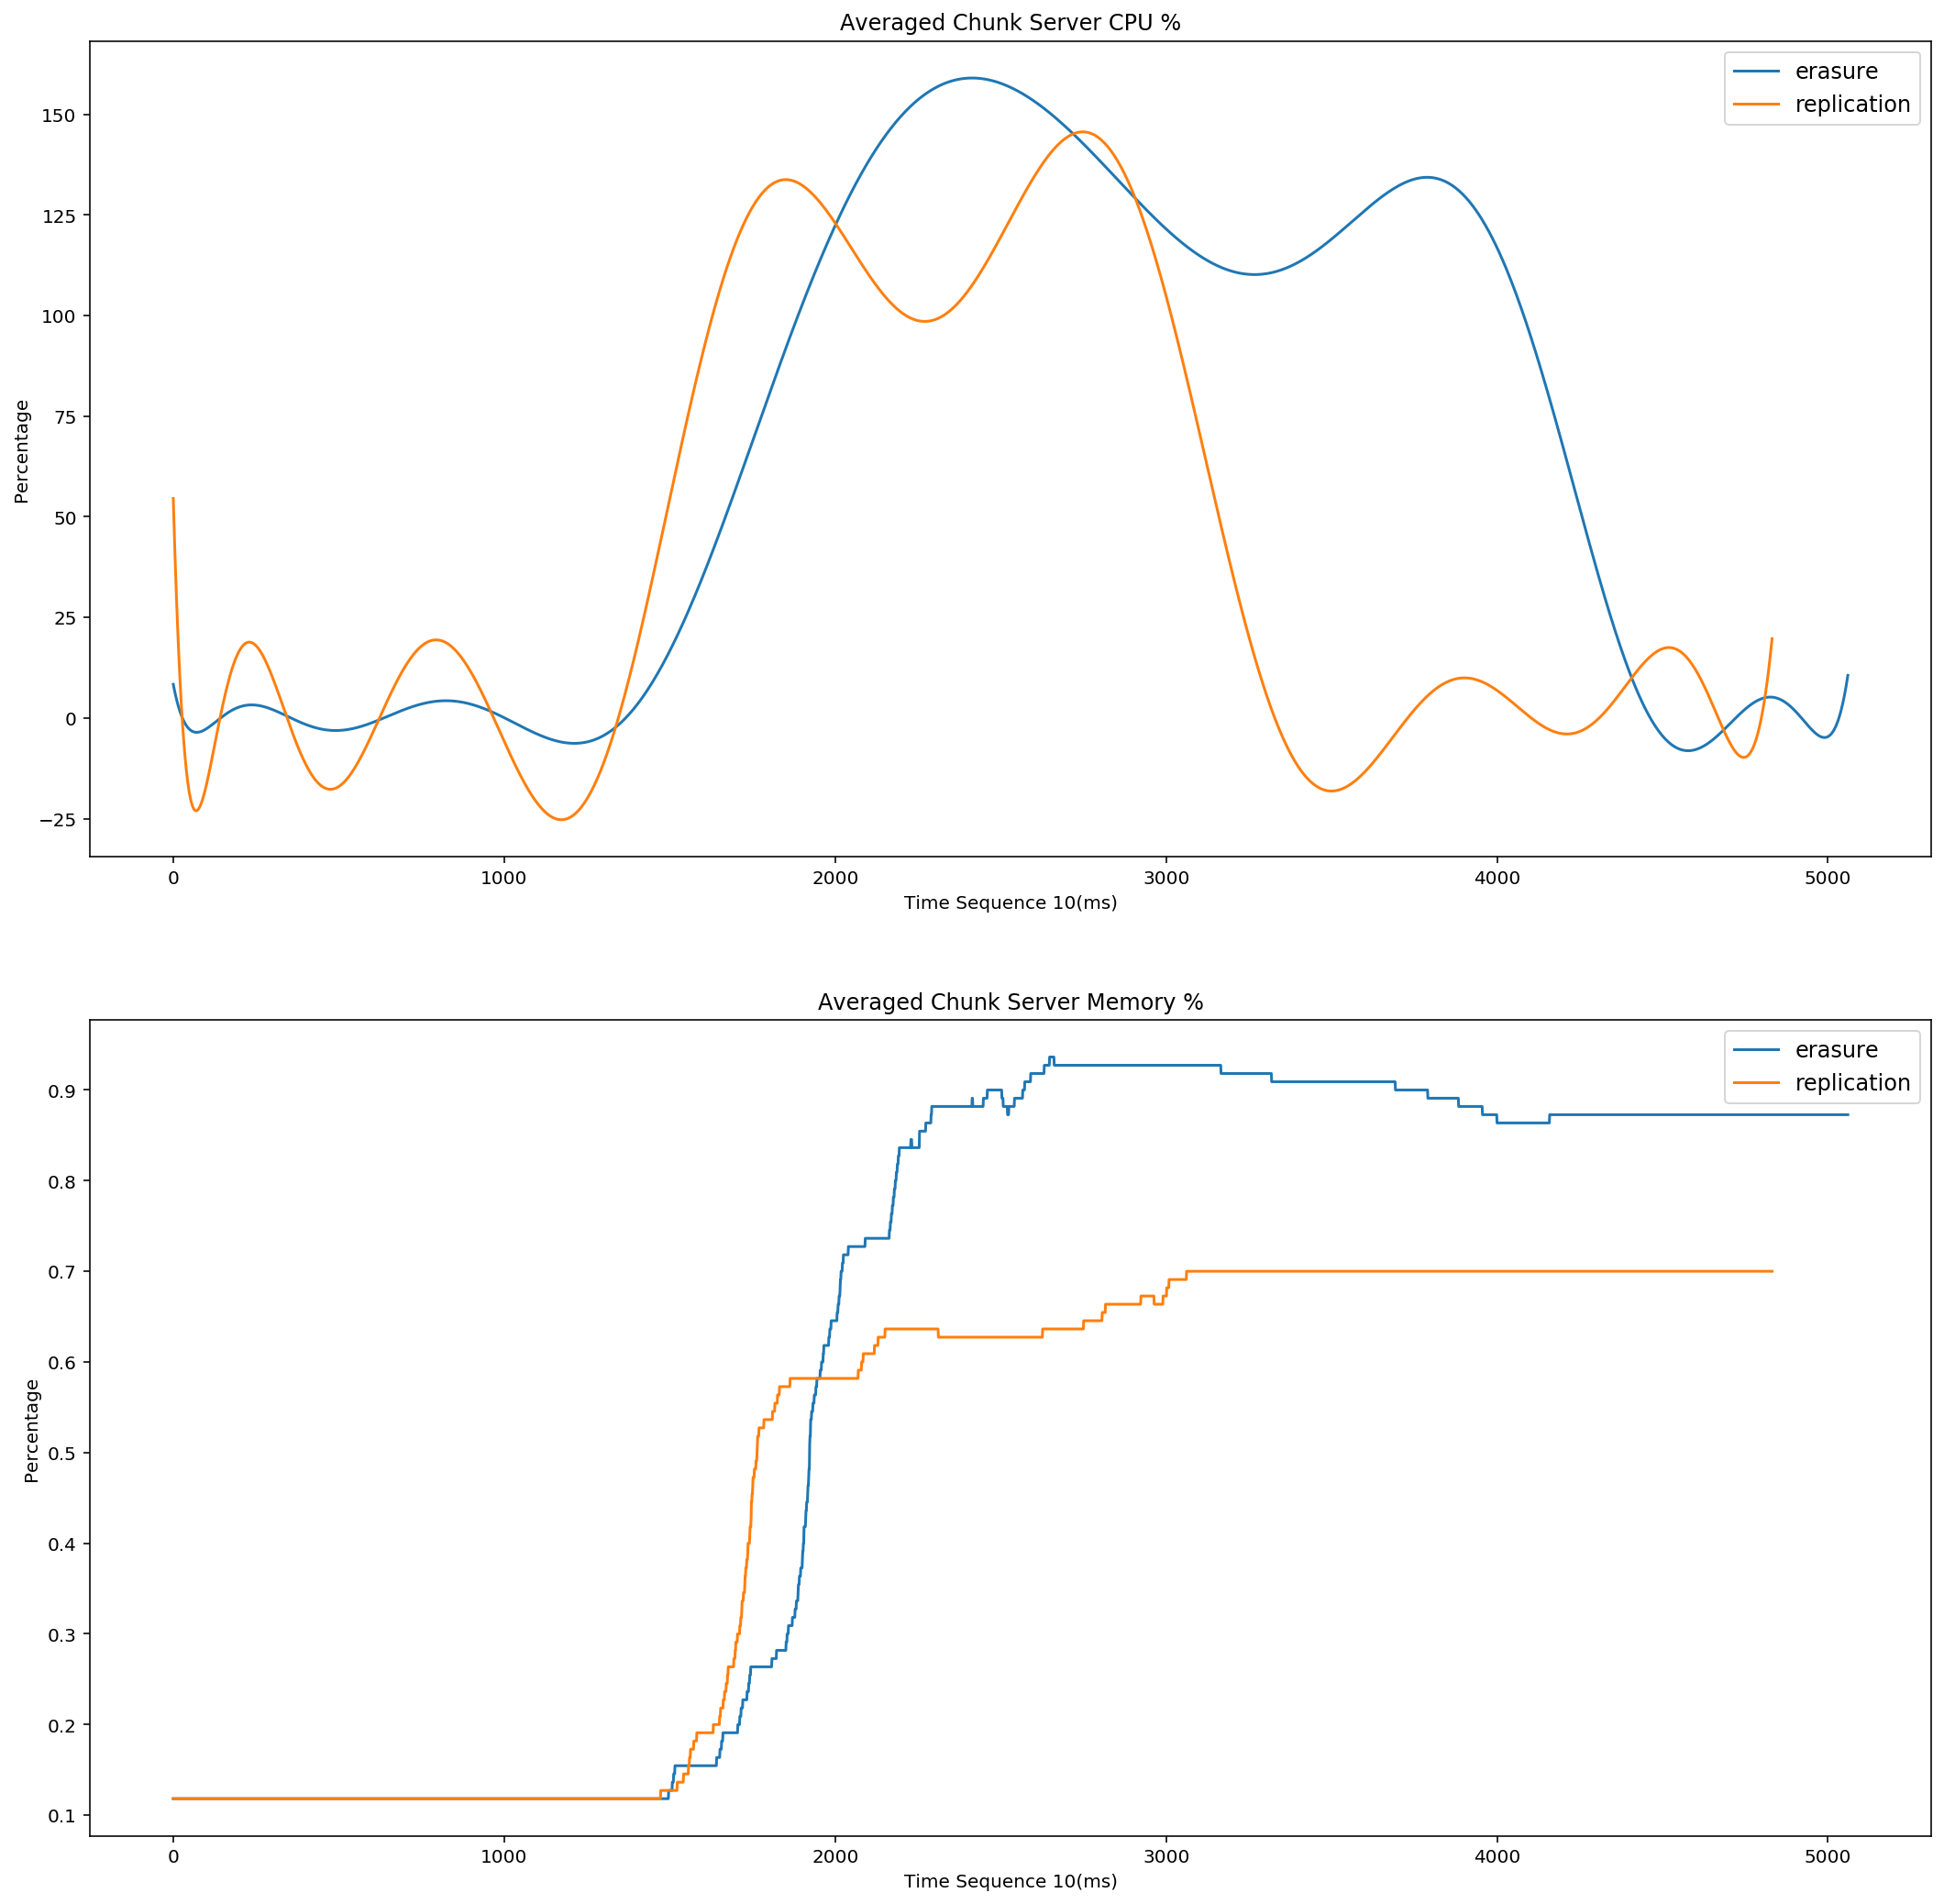

In [7]:
plot('Averaged Chunk Server', erasure_servers, replication_servers)

# Conclusion

With the consideration of application performance, it is evident that the schema for erasure coding with Reed-Solomon codes a more taxing process. This is the case for the client and the chunk servers alike. Whereas the controller is merrily transparent under the case of delivering data. The system undergoes various other operations, such as reading, and managing corrupted data and services. Reading has a similar performance benchmark as uploading data because the message size and operations are very similar. Under the schema for replication, there are minor operations for managing corrupt chunk slices and failed servers, but these are light weight operations that require minimal disk and network I/O.  

After this analysis, it is evident that if storage disk size is an issue and compute power is not, then the schema for erasure coding is preferable. On the contrary, if storage size is not an issue then using replication can be more stable with less performance implications.